In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py

from astropy.io import ascii, fits
from astropy.table import Table, join
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as cons
from astropy.visualization.wcsaxes import SphericalCircle

import scipy.integrate as integrate
from scipy.optimize import curve_fit

/home/elismar/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/elismar/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.3, Om0=0.27, Tcmb0=2.725)

[ 1.21154796e-05  4.39319909e-04 -2.11420409e-02  1.77834331e-01]


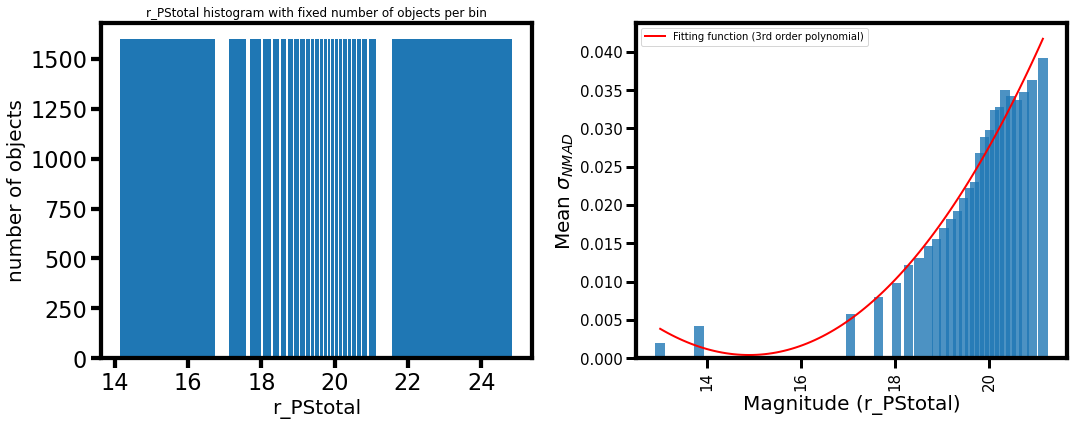

In [3]:
#Another way to do this would be to add an "__init__.py" to the folder '/work/Doc/galaxy-cluster-membership/' and import it as galaxy-cluster-membership.galaxy_cluster_membership I think
#See https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
import sys
sys.path.insert(1, '/work/Doc/galaxy-cluster-membership/')
from galaxy_cluster_membership import *

In [28]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc, rcParams
f = 0.8

fontsize = 35 * f
labelsize = 20 * f

rc("xtick", labelsize=fontsize * f)
rc("ytick", labelsize=fontsize * f)
rcParams["axes.linewidth"] = 5.3 * f
rcParams["xtick.major.width"] = 5.3 * f
rcParams["xtick.minor.width"] = 5.3 * f
rcParams["ytick.major.width"] = 5.3 * f
rcParams["ytick.minor.width"] = 5.3 * f
rcParams["xtick.major.size"] = 12.5 * f
rcParams["xtick.minor.size"] = 6.5 * f
rcParams["ytick.major.size"] = 12.5 * f
rcParams["ytick.minor.size"] = 6.5 * f

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 50 * f,
        }


cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')
cm3 = plt.cm.get_cmap('gnuplot2')

color_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colors1 = [cm1(value) for value in color_values]
colors2 = [cm2(value) for value in color_values]
colors3 = [cm3(value) for value in color_values]

### I have to identify some clusters in this mock in order to apply the membership over them
#### Start from here

In [5]:
hdul = fits.open("lightcone_zphot_subhalos_AllFrom1.fits")
scat = hdul[1].data

haloId = scat["haloId"]
galaxyId = scat["galaxyId"]
z_phot = scat["z_phot"]
z_spec = scat["z_app"]
ra = scat["RA"]
dec = scat["DEC"]
magr = scat["mag_r"]
firstHaloinFoFGroupId = scat["firstHaloinFoFGroupId"]

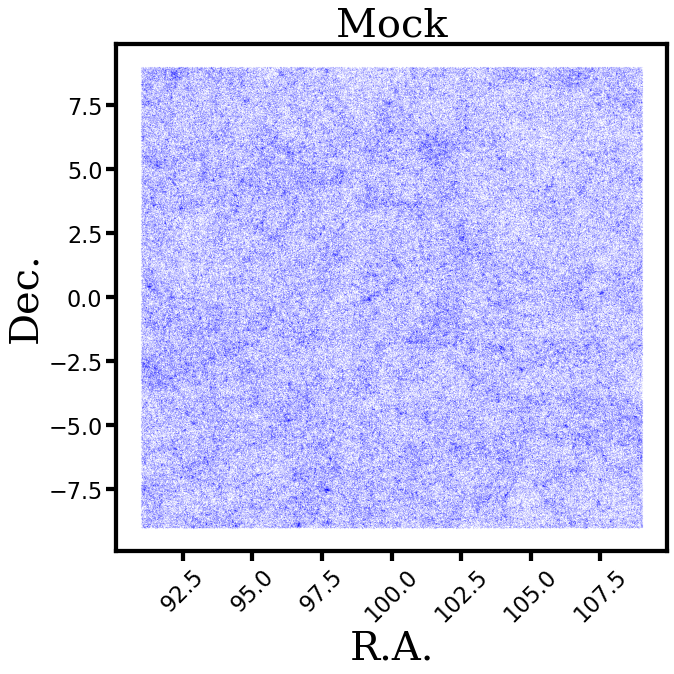

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

sc = ax.scatter(ra, dec, c="blue", s=0.0005)
ax.set_xlabel("R.A.", fontdict=font)
ax.set_ylabel("Dec.", fontdict=font)
ax.set_title("Mock", fontdict=font)

ax.tick_params(axis='x', rotation=45)
    
fig.tight_layout(pad=3.0)

Text(0, 0.5, 'Number of objects')

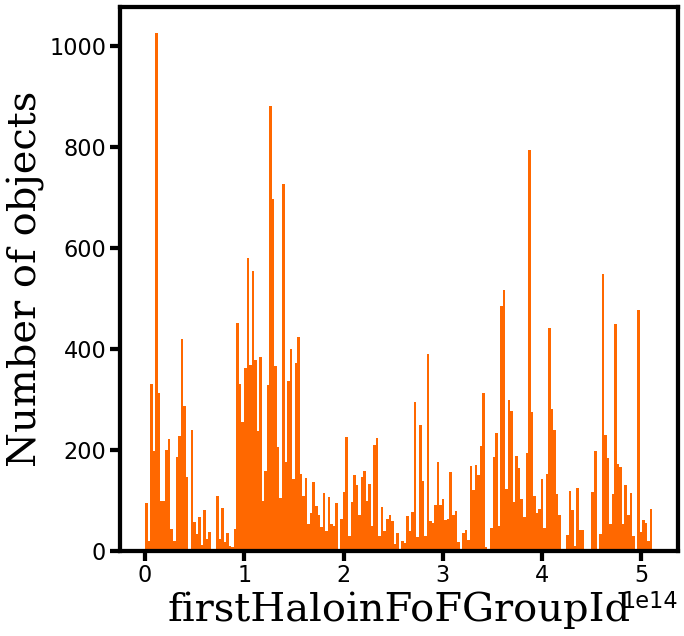

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.hist(firstHaloinFoFGroupId[firstHaloinFoFGroupId > 0], bins=200, color=colors1[7])[2]
ax.set_xlabel("firstHaloinFoFGroupId", fontdict=font)
ax.set_ylabel("Number of objects", fontdict=font)

### Let's determine the properties of the 10 most populated clusters of the mock

11
12
13
14
15
16
17
18
19
20


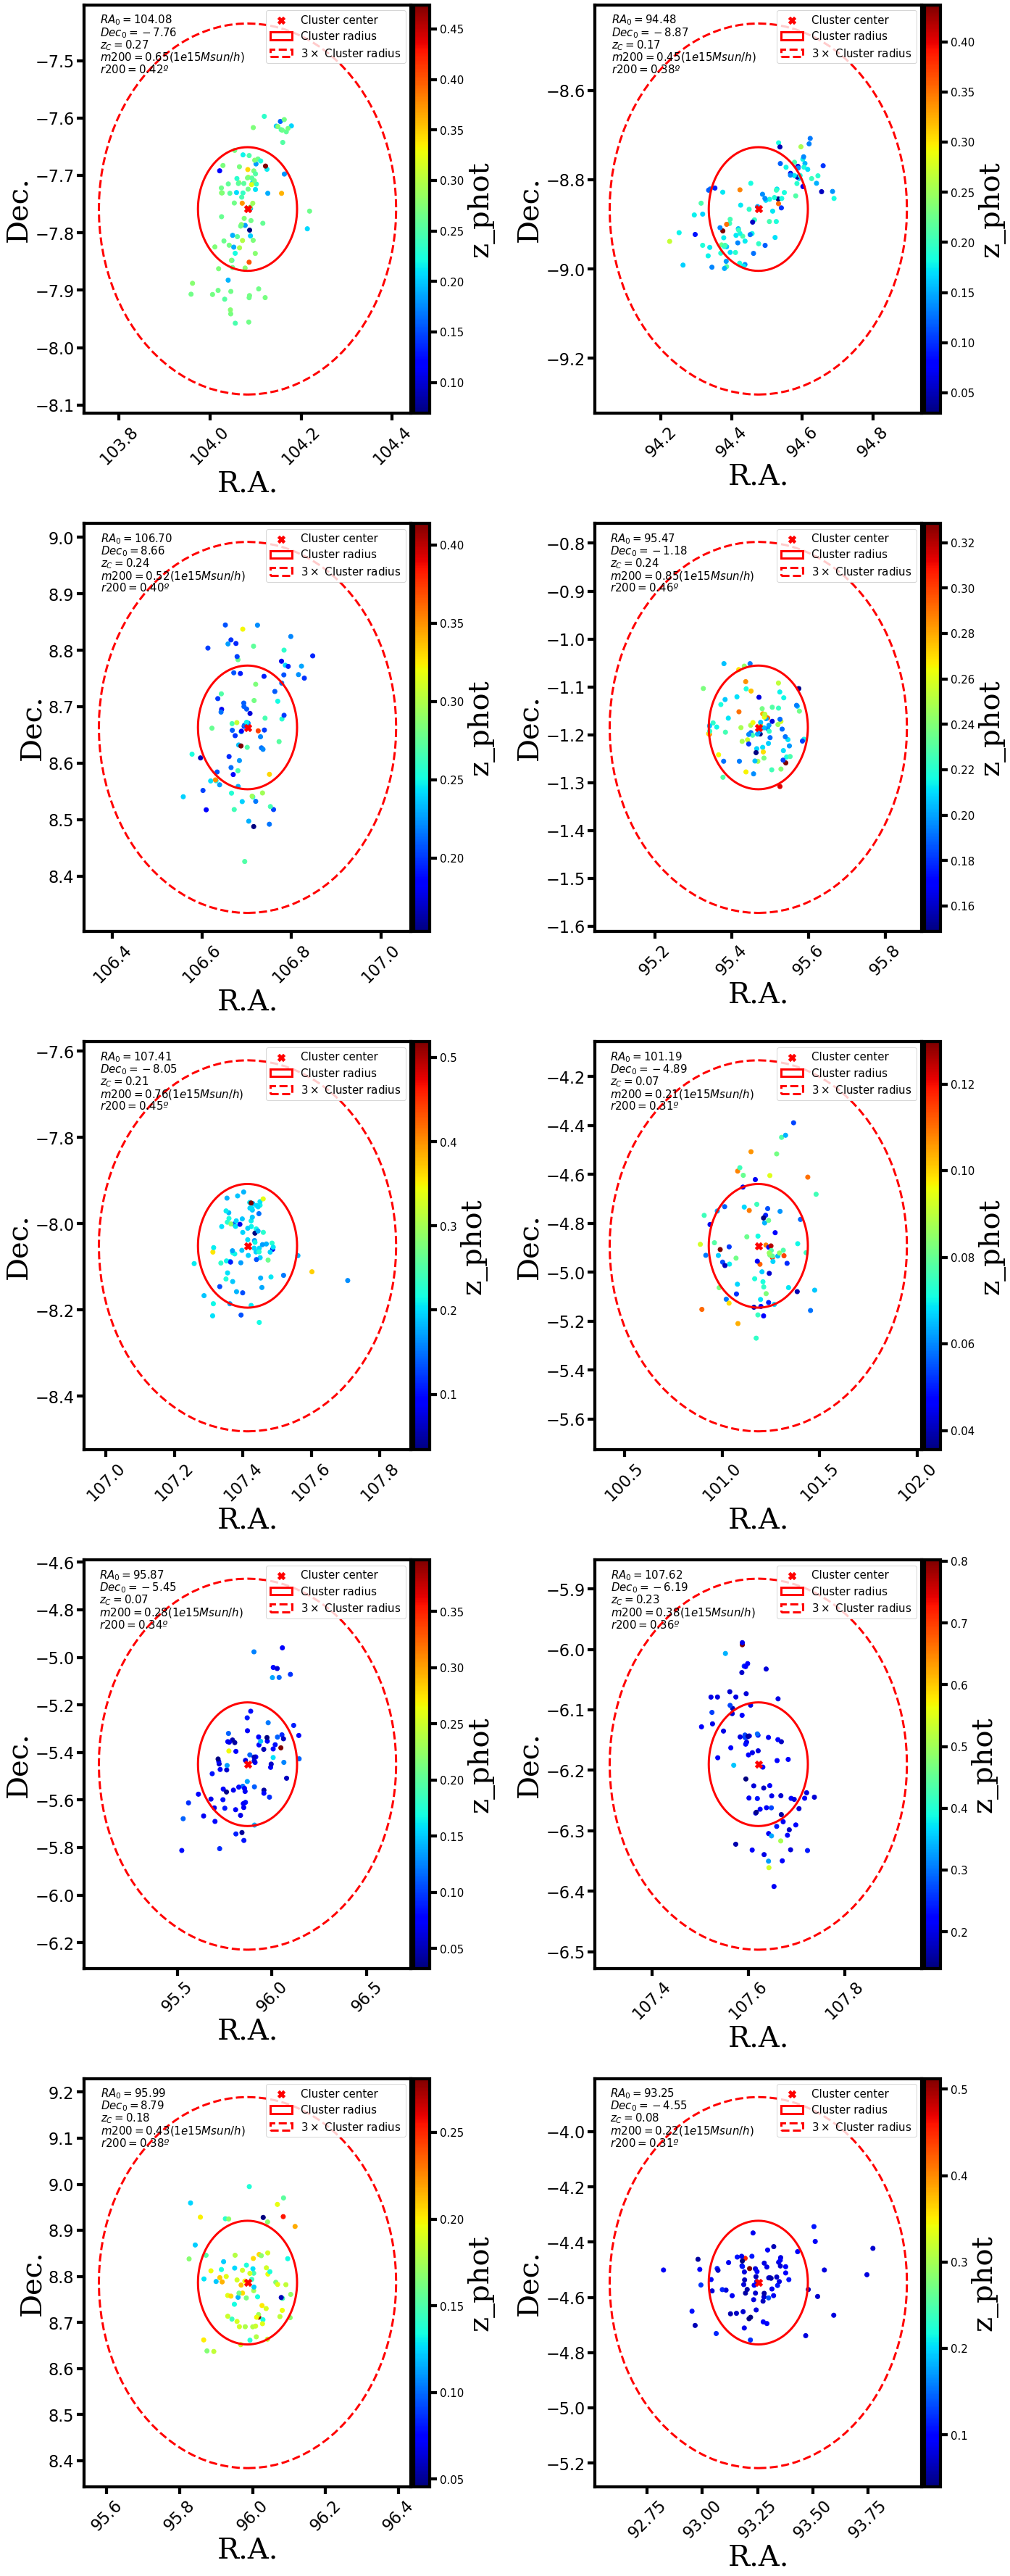

In [158]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 50))

for j in np.arange(11, 21, 1):
    
    print(j)

    halo_id = np.unique(firstHaloinFoFGroupId[firstHaloinFoFGroupId > 0])[halo_members_list == np.sort(halo_members_list)[-j]]
    if j == 11: halo_id = halo_id[0]
    if j == 12: halo_id = halo_id[1]
    if j == 13: halo_id = halo_id[0]
    if j == 14: halo_id = halo_id[1]
    if j == 16: halo_id = halo_id[0]
    if j == 17: halo_id = halo_id[1]
    
    halo_mask = firstHaloinFoFGroupId == halo_id

    halo_ra = ra[halo_mask]
    halo_dec = dec[halo_mask]
    halo_zphot = z_phot[halo_mask]
    halo_zspec = z_spec[halo_mask]
    halo_magr = magr[halo_mask]
    
    #Define some quantities for the cluster (center cordinates, redshift, radius, photo-z error (sigma))
    ra0 = np.mean(halo_ra)
    dec0 = np.mean(halo_dec)

    z_bins = 30
    i = np.argmax(np.histogram(halo_zspec, bins=z_bins)[0])
    z_cluster = np.histogram(halo_zspec, bins=z_bins)[1][i]
    
    m200 = scat["m_crit200"][halo_mask].max() * 1e10 * u.Msun / cosmo.h
    r200 = (m200 * cons.G / (100 * cosmo.H(z_cluster)**2))**(1/3)
    r200_mpc = r200.to(u.Mpc)
    kpc_scale = cosmo.kpc_proper_per_arcmin(z=z_cluster).value/60.
    r200_deg = r200_mpc.value*1000 / (kpc_scale * 3600)
    
    
    ax1 = axs[int(np.floor((j-11)/2)), (j-11)%2]
    sc = ax1.scatter(halo_ra, halo_dec, c=halo_zphot, cmap=cm1)
    ax1.set_xlabel("R.A.", fontdict=font)
    ax1.set_ylabel("Dec.", fontdict=font)

    ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")

    ax1.tick_params(axis='x', rotation=45)

    c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')

    r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
                lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
    ax1.add_patch(r1)

    r2 = SphericalCircle(c0, 3*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
                lw=3, label=r"$3 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
    ax1.add_patch(r2)
    
    ax1.text(ra0-3*r200_deg, dec0+3*r200_deg, s=r"$RA_0 = {:.2f}$".format(ra0), fontsize=15)
    ax1.text(ra0-3*r200_deg, dec0+2.8*r200_deg, s=r"$Dec_0 = {:.2f}$".format(dec0), fontsize=15)
    ax1.text(ra0-3*r200_deg, dec0+2.6*r200_deg, s=r"$z_C = {:.2f}$".format(z_cluster), fontsize=15)
    ax1.text(ra0-3*r200_deg, dec0+2.4*r200_deg, s=r"$m200 = {:.2f} (1e15 Msun/h)$".format(m200.value/1e15), fontsize=15)
    ax1.text(ra0-3*r200_deg, dec0+2.2*r200_deg, s=r"$r200 = {:.2f}º$".format(r200.value), fontsize=15)
    
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(sc, cax=cax1, orientation='vertical')
    cbar.set_label(label="z_phot", fontdict=font)
    cbar.ax.tick_params(labelsize=labelsize)

    ax1.legend(fontsize=labelsize)
    
    fig.tight_layout(pad=3.0)

### Defining properties of the cluster mock

In [8]:
#I have to apply the mask "firstHaloinFoFGroupId > 0" because otherwise I will have the value -9223372036854775808
#in it, which is actually a value assumed by python for the galaxies with no firstHaloinFoFGroupId assigned to it

halo_members_list = []
for i in range(len(np.unique(firstHaloinFoFGroupId[firstHaloinFoFGroupId > 0]))):
    halo_members = np.sum(firstHaloinFoFGroupId == np.unique(firstHaloinFoFGroupId[firstHaloinFoFGroupId > 0])[i])
    halo_members_list.append(halo_members)

In [9]:
#To select the five more populated halos, I just need to do the following for the 
#last five elements of np.sort(halo_members_list)

#I am selecting the haloId of the cluster with the higher number of elements
#To select the five most populated cluster, I just need to apply i = 1, 2, 3, 4, 5

i = 1
halo_id = np.unique(firstHaloinFoFGroupId[firstHaloinFoFGroupId > 0])[halo_members_list == np.sort(halo_members_list)[-i]]
halo_mask = firstHaloinFoFGroupId == halo_id

halo_ra = ra[halo_mask]
halo_dec = dec[halo_mask]
halo_zphot = z_phot[halo_mask]
halo_zspec = z_spec[halo_mask]
halo_magr = magr[halo_mask]

In [10]:
#Define some quantities for the cluster (center cordinates, redshift, radius, photo-z error (sigma))
ra0 = np.mean(halo_ra)
dec0 = np.mean(halo_dec)

#Three possibilities to define the cluster redshift: mean, median or peak of the redshift distribution
mean_z = np.mean(halo_zspec)
median_z = np.median(halo_zspec)

z_bins = 30
i = np.argmax(np.histogram(halo_zspec, bins=z_bins)[0])
z_peak = np.histogram(halo_zspec, bins=z_bins)[1][i]

z_cluster = z_peak

In [11]:
m200 = scat["m_crit200"][halo_mask].max() * 1e10 * u.Msun / cosmo.h

r200 = (m200 * cons.G / (100 * cosmo.H(z_cluster)**2))**(1/3)
r200_mpc = r200.to(u.Mpc)

kpc_scale = cosmo.kpc_proper_per_arcmin(z=z_cluster).value/60.
r200_deg = r200_mpc.value*1000 / (kpc_scale * 3600)

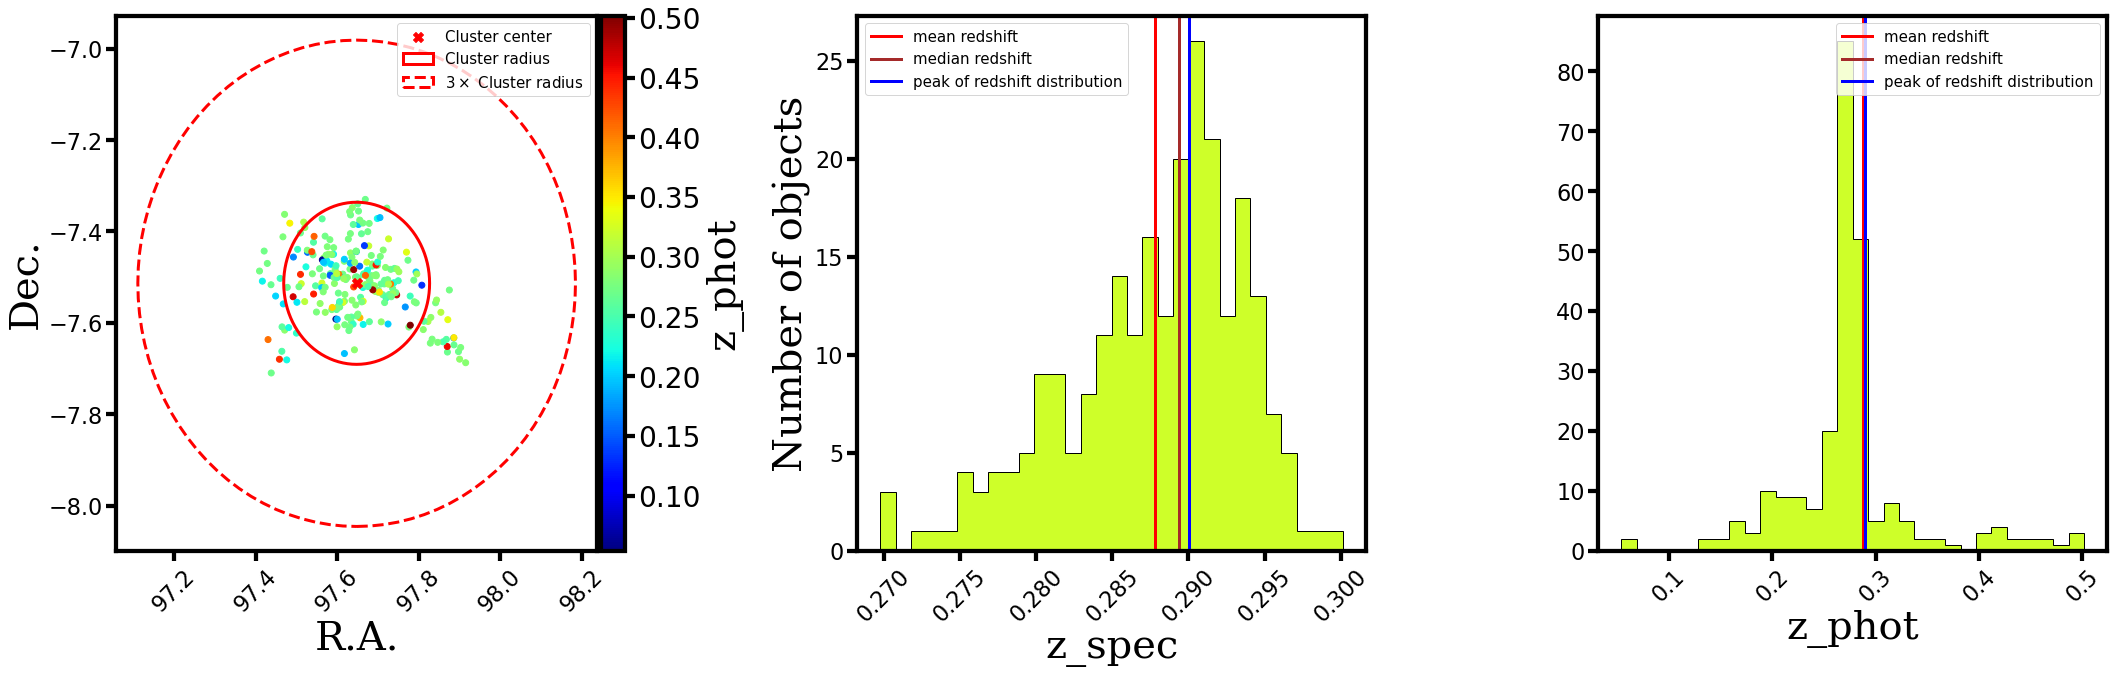

In [13]:
fig = plt.figure(figsize=(30, 10))


ax1 = fig.add_subplot(131)
sc = ax1.scatter(halo_ra, halo_dec, c=halo_zphot, cmap=cm1)
ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax1.set_xlabel("R.A.", fontdict=font)
ax1.set_ylabel("Dec.", fontdict=font)
ax1.tick_params(axis='x', rotation=45)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)

r2 = SphericalCircle(c0, 3*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$3 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r2)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax1, orientation='vertical')
cbar.set_label(label="z_phot", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax1.legend(fontsize=15)


ax2 = fig.add_subplot(132)
ax2.hist(halo_zspec, bins=z_bins, color=colors1[5], histtype='stepfilled', edgecolor='k')[2]
ax2.set_xlabel("z_spec", fontdict=font)
ax2.set_ylabel("Number of objects", fontdict=font)
ax2.axvline(mean_z, color="red", lw=3, label="mean redshift")
ax2.axvline(median_z, color="brown", lw=3, label="median redshift")
ax2.axvline(z_cluster, color="blue", lw=3, label="peak of redshift distribution")
ax2.tick_params(axis='x', rotation=45)
ax2.legend(fontsize=15)


ax3 = fig.add_subplot(133)
ax3.hist(halo_zphot, bins=z_bins, color=colors1[5], histtype='stepfilled', edgecolor='k')[2]
ax3.set_xlabel("z_phot", fontdict=font)
# ax3.set_ylabel("Number of objects", fontdict=font)
ax3.axvline(mean_z, color="red", lw=3, label="mean redshift")
ax3.axvline(median_z, color="brown", lw=3, label="median redshift")
ax3.axvline(z_cluster, color="blue", lw=3, label="peak of redshift distribution")
ax3.tick_params(axis='x', rotation=45)
ax3.legend(fontsize=15)
    
    
fig.tight_layout(pad=3.0)

### Dealing with the photo-zs of the mock

There are two issues associated with the photo-zs: <br>
- In the case of the mock, the photo-zs are just single point estimates (SPEs), so that I was having to simulate them as simple gaussians centered on these SPE values. Although, a real photo-z PDF has three associated means, weights and stds, each one for one of the gaussians of the Gaussian Mixture Model used by Erik in his method. Therefore, to associate real PDF attributes to the photo-zs of galaxies in the mock, I will apply a KNN method to find for galaxies in Erik's photo-z training sample with similar properties to the ones in the mock, and then assign the photo-z PDF properties of these real galaxies to them;
- The other issue is that the photo-zs of the galaxies have a small shift (bias) compared to the cluster redshift. It is a good idea to correct for this bias before applying the method.

I just defined the center and the redshift of the cluster, i.e., the center is given by mean of RA and DEC positions of galaxies in the clister (halo), and the redshift is the mean value of spectroscopic redshifts of galaxies in the cluster (maybe we could consider the median, but it it very similar to the mean). <br>

Next step is to get all field galaxies in the region of the cluster. I am thinking of doing it by considering a circular region of the cluster with a radius equals to the larger distance between a galaxy in the cluster an the center of the cluster. Then the field galaxies will be all galaxies distancing less than this radius from the center of the cluster.

In [14]:
#Computing the distance between all galaxies that I know are not in the cluster and the center of the cluster
dist_field = clustercentric_distance(ra[~halo_mask], dec[~halo_mask], ra0, dec0)

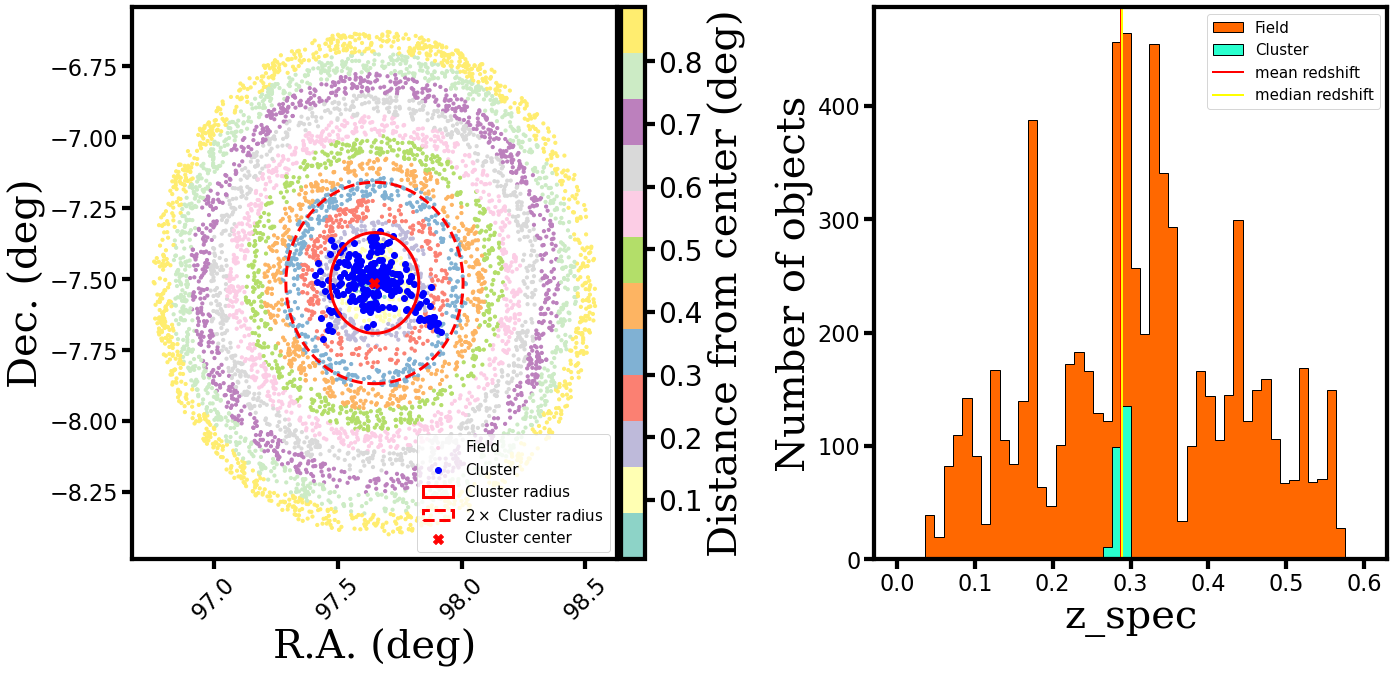

In [19]:
fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(121)
max_dist = 5*r200_deg
sc = ax1.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], 
                c=dist_field[dist_field < max_dist], cmap=cm.Set3, s=10, label="Field")

sc2 = ax1.scatter(halo_ra, halo_dec, c="blue", label="Cluster")

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)

r2 = SphericalCircle(c0, 2*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$2 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r2)

ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)

ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")

ax1.tick_params(axis='x', rotation=45)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax1, orientation='vertical')
cbar.set_label(label="Distance from center (deg)", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax1.legend(fontsize=15)



max_z = 0.6
ax2 = fig.add_subplot(122)

ax2.hist(z_spec[~halo_mask][dist_field < max_dist], bins=50, 
        color=colors1[7], histtype='stepfilled', edgecolor='k', range=[0, max_z], label="Field")[2]

ax2.hist(halo_zspec, bins=50, color=colors1[3], histtype='stepfilled', edgecolor='k',
        range=[0, max_z], label="Cluster")[2]

ax2.set_xlabel("z_spec", fontdict=font)
ax2.set_ylabel("Number of objects", fontdict=font)

ax2.axvline(mean_z, color="red", lw=2, label="mean redshift")
ax2.axvline(median_z, color="yellow", lw=2, label="median redshift")
ax2.legend(fontsize=15)


fig.tight_layout(pad=3.0)

### Start of the membership procedure


In [16]:
dist = clustercentric_distance(ra, dec, ra0, dec0)

In [164]:
sigma_z = np.array([sigma_nmad(r) for r in magr])

#Define the volume of the cluster
#fz1 determines the extent of the "mask_cluster", fz2 determines the extent to compute P(C | zp), and fr defines the radial extent of the objects
fz1 = 2.0
fz2 = 2.0
fr = 5.0

#This mask defines all galaxies in the fr*R200 projected area of the cluster
mask_cluster_region = dist < fr*r200_deg

#This one restricts the above mask to only the galaxies delimited by +/-fz*sigma from the cluster redshift, defining a list of candidate members
mask_cluster = mask_cluster_region & (z_phot > z_cluster - fz1*sigma_z*(1+z_cluster)) & (z_phot < z_cluster + fz1*sigma_z*(1+z_cluster))

In [138]:
P_pz_C_array = P_pz_v2_mock(z_cluster, z_phot[mask_cluster], magr[mask_cluster], fz=fz2)

### Compute purity and completeness

To estimate completeness and purity for P(C | zp), I will define the true cluster members + infalling galaxies as the ones selected via 3-sigma-clipping on the spectroscopic redshifts

In [139]:
z_lower = 0.27
z_upper = 0.3

z_members, id_members = sigma_clipping(z_spec[mask_cluster], galaxyId[mask_cluster], z_lower, z_upper, 3.0)
mask_members = np.isin(galaxyId[mask_cluster], id_members)

In [140]:
completeness_zp = []
purity_zp = []
d = 0.01
Pmem_cut_arr_zp = np.arange(0.0, 1.0, d)

for Pmem_cut in Pmem_cut_arr_zp:
    
    c = np.sum((P_pz_C_array > Pmem_cut) & mask_members) / np.sum(mask_members)
    p = np.sum((P_pz_C_array > Pmem_cut) & mask_members) / np.sum(P_pz_C_array > Pmem_cut)
    
    completeness_zp.append(c)
    purity_zp.append(p)

In [141]:
#We need a criterium to determine a cut P(C | zp) > p0. One way is by optimizing the F1 score, defined below.
completeness_zp = np.array(completeness_zp)
purity_zp = np.array(purity_zp)

F1_zp = 2 * completeness_zp*purity_zp/(completeness_zp + purity_zp)

cut_zp = Pmem_cut_arr_zp[np.argmax(F1_zp)]

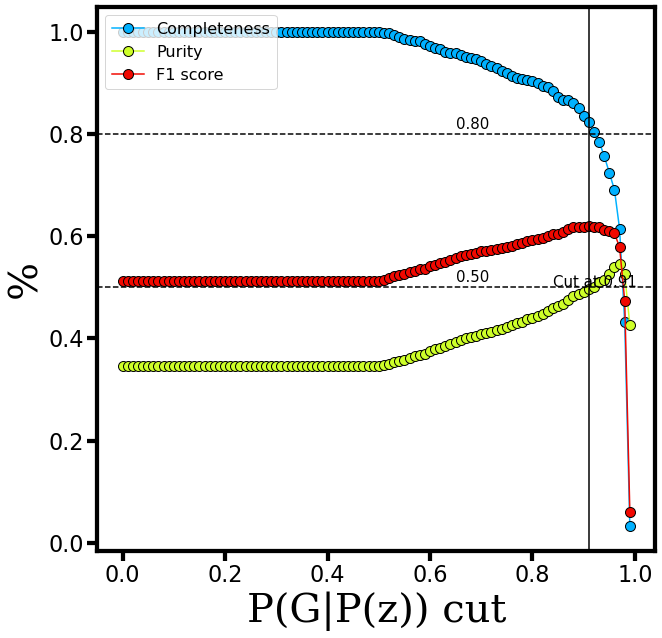

In [146]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ms = 10
ax1.plot(Pmem_cut_arr_zp, completeness_zp, marker='o', color=colors1[2],
         label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_zp, purity_zp, marker='o', color=colors1[5], 
         label="Purity", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_zp, F1_zp, marker='o', color=colors1[8], 
         label="F1 score", markersize=ms, markeredgecolor="black")


ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel("P(C|P(z)) cut", fontdict=font)

ax1.axvline(cut_zp, color="black")
ax1.text(x=cut_zp-0.07, y=0.5, s="Cut at {:.2f}".format(cut_zp), fontsize=15)

c_best = 0.80
ax1.axhline(c_best, color="black", linestyle="dashed")
ax1.text(0.65, y=c_best+0.01, s="{:.2f}".format(c_best), fontsize=15)

p_best = 0.50
ax1.axhline(p_best, color="black", linestyle="dashed")
ax1.text(0.65, y=p_best+0.01, s="{:.2f}".format(p_best), fontsize=15)

ax1.legend(fontsize=labelsize, loc=2)

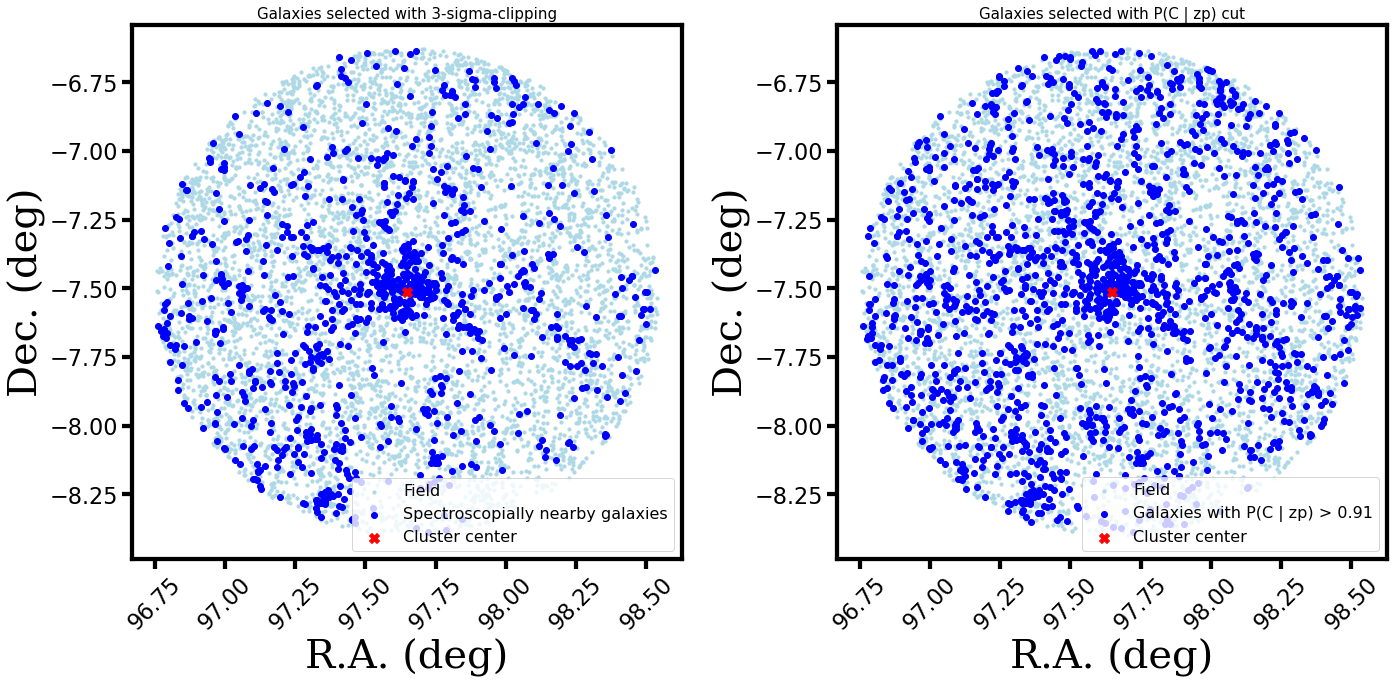

In [147]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], 
                c="lightblue", s=10, label="Field")
ax1.scatter(ra[mask_cluster][mask_members], dec[mask_cluster][mask_members], c="blue", label="Spectroscopially nearby galaxies")
ax1.set_title("Galaxies selected with 3-sigma-clipping", fontsize=15)
ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)
ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax1.legend(fontsize=labelsize)
ax1.tick_params(axis='x', rotation=45)

ax2.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], 
                c="lightblue", s=10, label="Field")
ax2.scatter(ra[mask_cluster][P_pz_C_array > cut_zp], dec[mask_cluster][P_pz_C_array > cut_zp], c="blue", 
                label="Galaxies with P(C | zp) > {:.2f}".format(cut_zp))
ax2.set_title("Galaxies selected with P(C | zp) cut", fontsize=15)
ax2.set_xlabel("R.A. (deg)", fontdict=font)
ax2.set_ylabel("Dec. (deg)", fontdict=font)
ax2.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax2.legend(fontsize=labelsize)
ax2.tick_params(axis='x', rotation=45)

    
fig.tight_layout(pad=3.0)

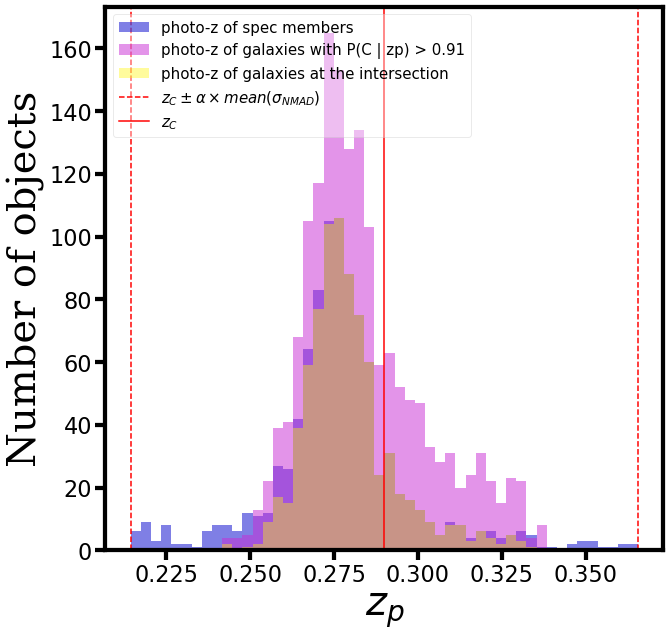

In [148]:
bins = 50

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ax1.hist(z_phot[mask_cluster][mask_members], bins=bins, histtype='stepfilled', 
         color=colors3[1], alpha=0.5, label="photo-z of spec members", range=[z_cluster - fz1*np.mean(sigma_z)*(1+z_cluster), 
                                                                             z_cluster + fz1*np.mean(sigma_z)*(1+z_cluster)])
ax1.hist(z_phot[mask_cluster][P_pz_C_array > cut_zp], bins=bins, histtype='stepfilled', 
         color=colors3[4], alpha=0.5, label="photo-z of galaxies with P(C | zp) > {:.2f}".format(cut_zp), range=[z_cluster - fz1*np.mean(sigma_z)*(1+z_cluster), 
                                                                                                                 z_cluster + fz1*np.mean(sigma_z)*(1+z_cluster)])
ax1.hist(z_phot[mask_cluster][(P_pz_C_array > cut_zp) & mask_members], bins=bins, histtype='stepfilled', 
         color=colors3[8], alpha=0.4, label="photo-z of galaxies at the intersection", range=[z_cluster - fz1*np.mean(sigma_z)*(1+z_cluster), 
                                                                                                                 z_cluster + fz1*np.mean(sigma_z)*(1+z_cluster)])

ax1.axvline(z_cluster - fz1*np.mean(sigma_z)*(1+z_cluster), color="red", ls='--')
ax1.axvline(z_cluster + fz1*np.mean(sigma_z)*(1+z_cluster), color="red", ls='--', label=r"$z_C \pm \alpha \times mean(\sigma_{NMAD})$")
ax1.axvline(z_cluster, color="red", label=r"$z_C$")

ax1.set_xlabel(r"$z_p$", fontdict=font)
ax1.set_ylabel("Number of objects", fontdict=font)
ax1.legend(fontsize=15, loc=2, framealpha=0.4)

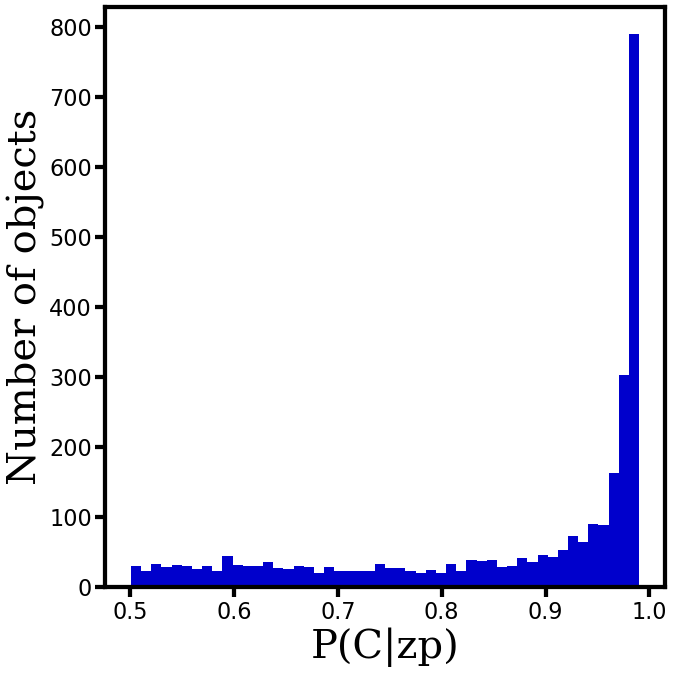

In [149]:
bins = 50
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
ax1.hist(P_pz_C_array, bins=bins, histtype='stepfilled', 
         color=colors3[1], alpha=1.0)
ax1.set_xlabel("P(C|zp)", fontdict=font)
ax1.set_ylabel("Number of objects", fontdict=font)

fig.tight_layout(pad=3.0)

### Comparing the selection using $\sigma_{NMAD}$ cut with the probabilistic method (using photo-z PDFs)

In [223]:
completeness_alpha = []
purity_alpha = []

fz_array = np.arange(1.0, 5.5, 0.5)

for fz in fz_array:
    mask_cluster = mask_cluster_region & (z_phot > z_cluster - fz*sigma_z*(1+z_cluster)) & (z_phot < z_cluster + fz*sigma_z*(1+z_cluster))
    
    c = np.sum(np.isin(galaxyId[halo_mask], galaxyId[mask_cluster])) / len(galaxyId[halo_mask])
    p = np.sum(np.isin(galaxyId[mask_cluster], galaxyId[halo_mask])) / len(galaxyId[mask_cluster])
    
    completeness_alpha.append(c)
    purity_alpha.append(p)

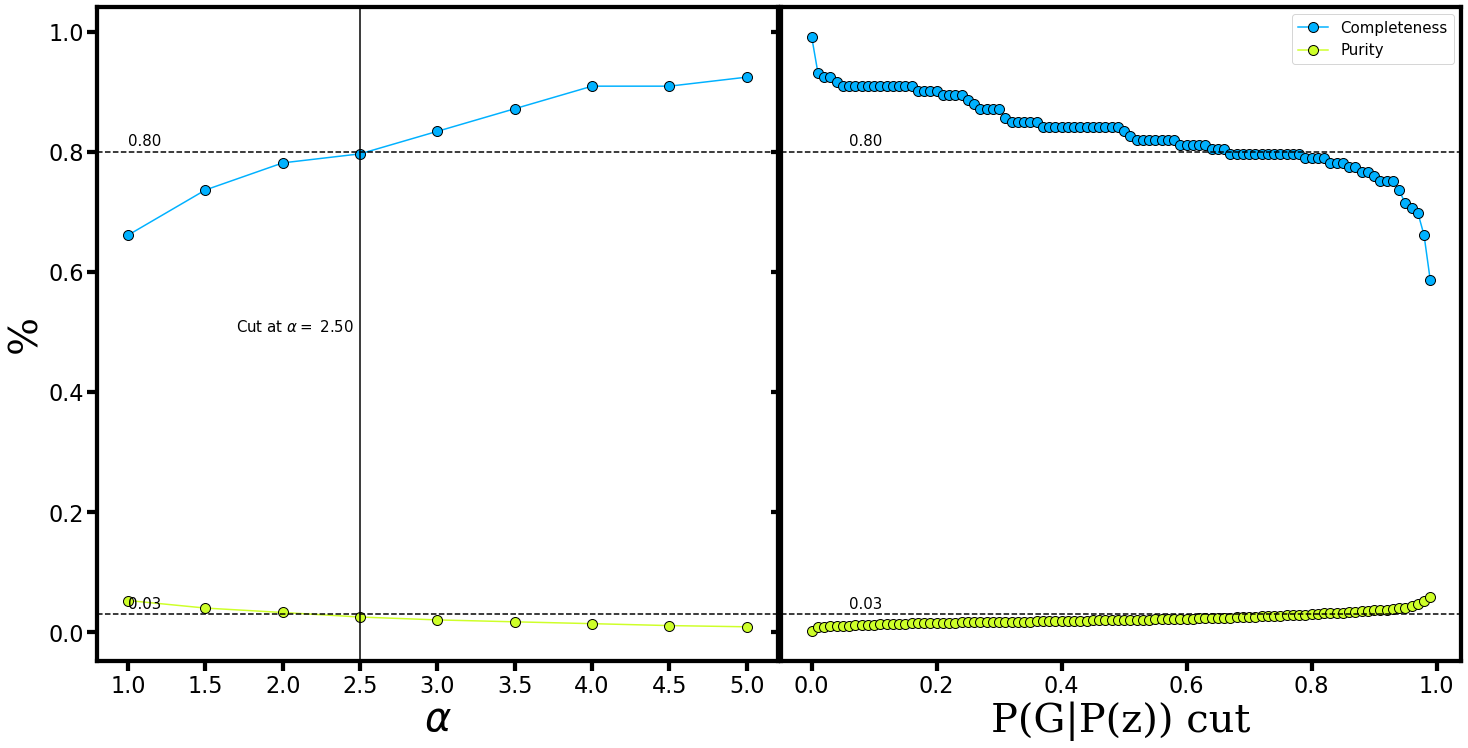

In [233]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
ms = 10

ax1 = axs[0]
ax1.plot(fz_array, completeness_alpha, marker='o', color=colors1[2],label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(fz_array, purity_alpha, marker='o', color=colors1[5], label="Purity", markersize=ms, markeredgecolor="black")
ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel(r"$\alpha$", fontdict=font)

c_best = 0.80
ax1.axhline(c_best, color="black", linestyle="dashed")
ax1.text(1.0, y=c_best+0.01, s="{:.2f}".format(c_best), fontsize=15)

p_best = 0.03
ax1.axhline(p_best, color="black", linestyle="dashed")
ax1.text(1.0, y=p_best+0.01, s="{:.2f}".format(p_best), fontsize=15)

cut_alpha = 2.5
ax1.axvline(cut_alpha, color="black")
ax1.text(x=cut_alpha-0.8, y=0.5, s=r"Cut at $\alpha =$ {:.2f}".format(cut_alpha), fontsize=15)


ax2 = axs[1]
ax2.plot(Pmem_cut_arr_zp, completeness_zp, marker='o', color=colors1[2], label="Completeness", markersize=ms, markeredgecolor="black")
ax2.plot(Pmem_cut_arr_zp, purity_zp, marker='o', color=colors1[5], label="Purity", markersize=ms, markeredgecolor="black")
ax2.set_xlabel("P(G|P(z)) cut", fontdict=font)
ax2.legend(fontsize=labelsize, loc=1)

# cut = 0.22
# ax2.axvline(cut, color="black")
# ax2.text(x=cut-0.26, y=0.5, s=r"Cut at $P(C|z_p) =$ {:.2f}".format(cut), fontsize=15)

ax2.axhline(c_best, color="black", linestyle="dashed")
ax2.text(0.06, y=c_best+0.01, s="{:.2f}".format(c_best), fontsize=15)

ax2.axhline(p_best, color="black", linestyle="dashed")
ax2.text(0.06, y=p_best+0.01, s="{:.2f}".format(p_best), fontsize=15)


fig.tight_layout(pad=-0.7)

### Radial probabilities

In [165]:
#To go to the radial probabilities, we have to define a cut in P(C | zp), computed above
mask_cluster_zp = P_pz_C_array > cut_zp

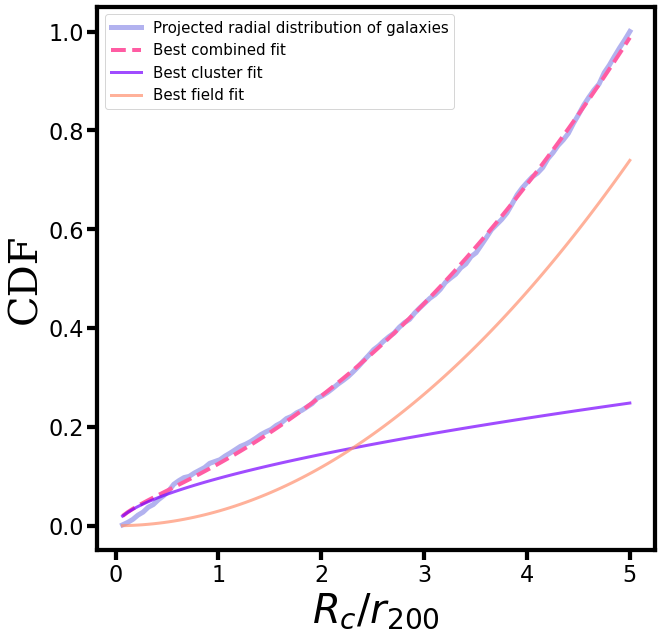

In [166]:
Pmem_R_C, Pmem_R_F = radial_mem_prob(dist[mask_cluster][mask_cluster_zp], rc=r200_deg, plot=True)

In [168]:
completeness_R = []
purity_R = []
d = 0.01
Pmem_cut_arr_R = np.arange(0.0, 1.0, d)

for Pmem_cut in Pmem_cut_arr_R:
    
    c = np.sum(np.isin(galaxyId[halo_mask], galaxyId[mask_cluster][mask_cluster_zp][Pmem_R_C > Pmem_cut])) / len(galaxyId[halo_mask])
    p = np.sum(np.isin(galaxyId[mask_cluster][mask_cluster_zp][Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(galaxyId[mask_cluster][mask_cluster_zp][Pmem_R_C > Pmem_cut])
    
    completeness_R.append(c)
    purity_R.append(p)

In [169]:
#We need a criterium to determine a cut P(C | zp) > p0. One way is by optimizing the F1 score, defined below.
completeness_R = np.array(completeness_R)
purity_R = np.array(purity_R)

F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)

cut_R = Pmem_cut_arr_R[np.argmax(F1_R[~np.isnan(F1_R)])]

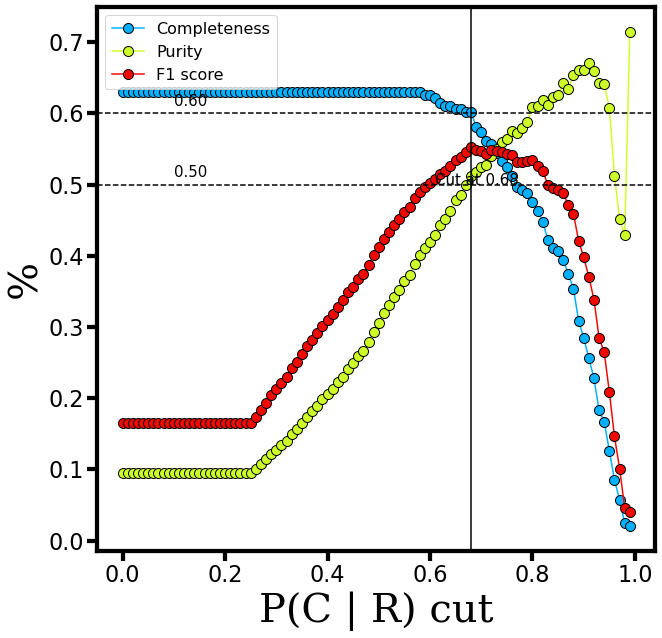

In [172]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ms = 10
ax1.plot(Pmem_cut_arr_R, completeness_R, marker='o', color=colors1[2],
         label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_R, purity_R, marker='o', color=colors1[5], 
         label="Purity", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_R, F1_R, marker='o', color=colors1[8], 
         label="F1 score", markersize=ms, markeredgecolor="black")


ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel("P(C | R) cut", fontdict=font)

ax1.axvline(cut_R, color="black")
ax1.text(x=cut_R-0.07, y=0.5, s="Cut at {:.2f}".format(cut_R), fontsize=15)

c_best = 0.60
ax1.axhline(c_best, color="black", linestyle="dashed")
ax1.text(0.10, y=c_best+0.01, s="{:.2f}".format(c_best), fontsize=15)

p_best = 0.50
ax1.axhline(p_best, color="black", linestyle="dashed")
ax1.text(0.10, y=p_best+0.01, s="{:.2f}".format(p_best), fontsize=15)


ax1.legend(fontsize=labelsize, loc=2)

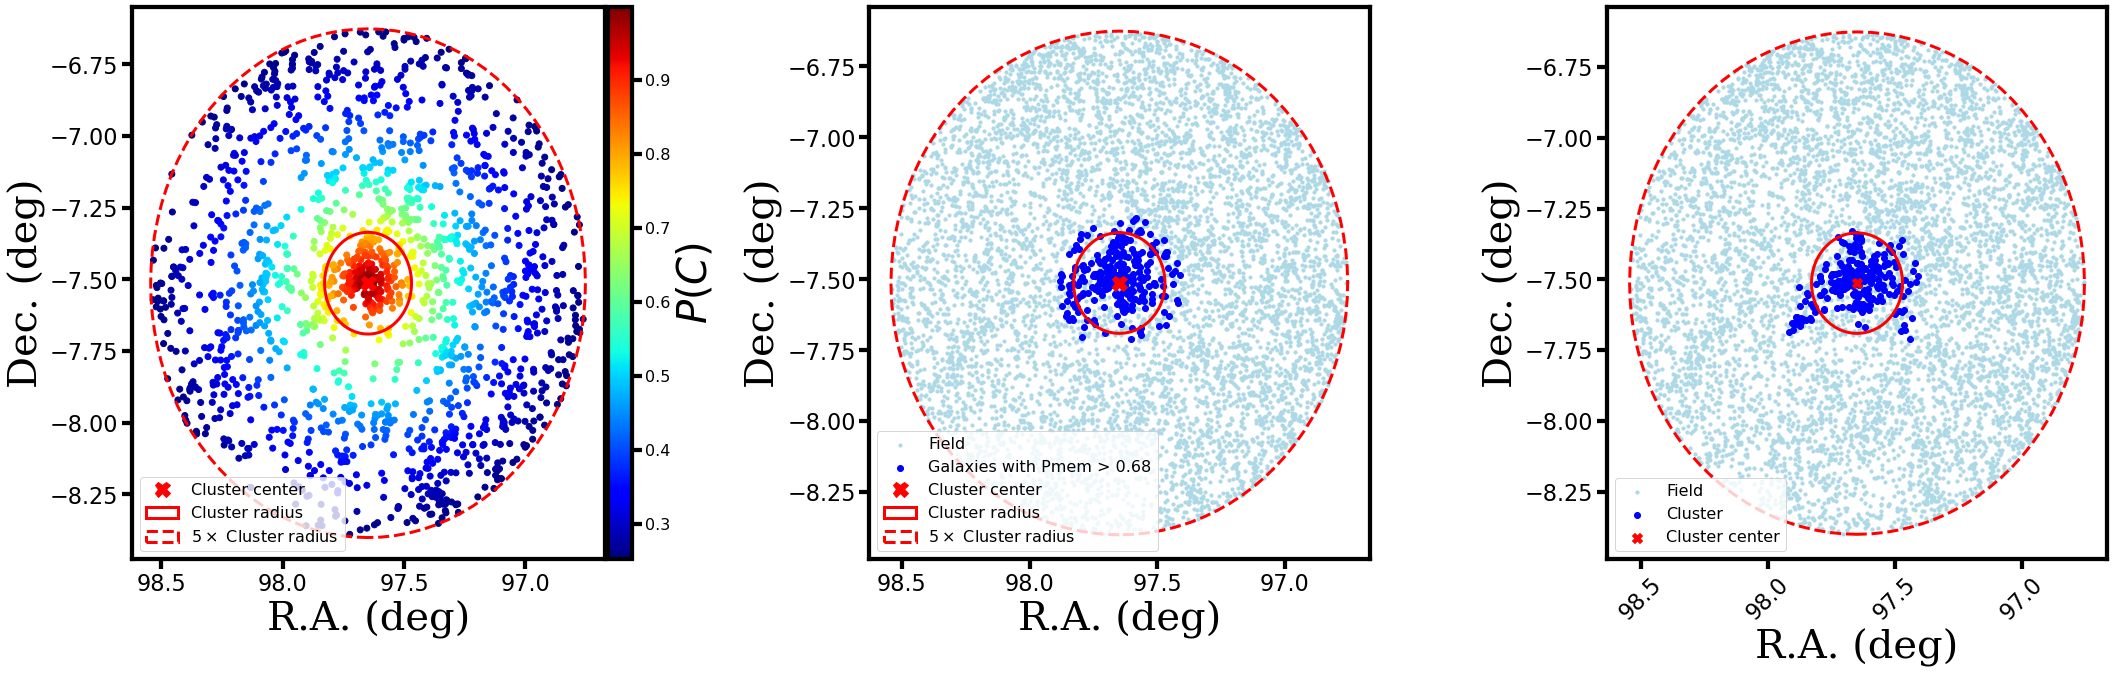

In [175]:
fig = plt.figure(figsize=(30, 10))


ax1 = fig.add_subplot(131)
sc1 = ax1.scatter(ra[mask_cluster][mask_cluster_zp], dec[mask_cluster][mask_cluster_zp], 
                  marker='o', c=Pmem_R_C, cmap="jet", rasterized=True)
ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)
ax1.invert_xaxis()
# ax1.set_title(cl_names[cluster], fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$P(C)$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)

r5 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r5)
ax1.legend(fontsize=labelsize)



ax2 = fig.add_subplot(132)
ax2.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], c="lightblue", s=10, label="Field")
sc2 = ax2.scatter(ra[mask_cluster][mask_cluster_zp][Pmem_R_C > cut_R], dec[mask_cluster][mask_cluster_zp][Pmem_R_C > cut_R],
                  marker='o', c="blue", rasterized=True, label="Galaxies with Pmem > {:.2f}".format(cut_R))
ax2.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax2.set_xlabel("R.A. (deg)", fontdict=font)
ax2.set_ylabel("Dec. (deg)", fontdict=font)
ax2.invert_xaxis()

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax2.add_patch(r1)
r5 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax2.add_patch(r5)
ax2.legend(fontsize=labelsize)



ax3 = fig.add_subplot(133)
ax3.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], 
                c="lightblue", s=10, label="Field")
ax3.scatter(halo_ra, halo_dec, c="blue", label="Cluster")
ax3.set_xlabel("R.A. (deg)", fontdict=font)
ax3.set_ylabel("Dec. (deg)", fontdict=font)
ax3.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax3.legend(fontsize=labelsize)
ax3.tick_params(axis='x', rotation=45)

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax3.add_patch(r1)
r5 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax3.add_patch(r5)
ax3.invert_xaxis()


fig.tight_layout(pad=3.0)

# plt.savefig("../figures/clusters-membership/RA_DEC_z_distribution_{}.png".format(cl_names[cluster]), dpi='figure', format='png')

### Unifying potentially infalling galaxies with potential member galaxies on the same plot:

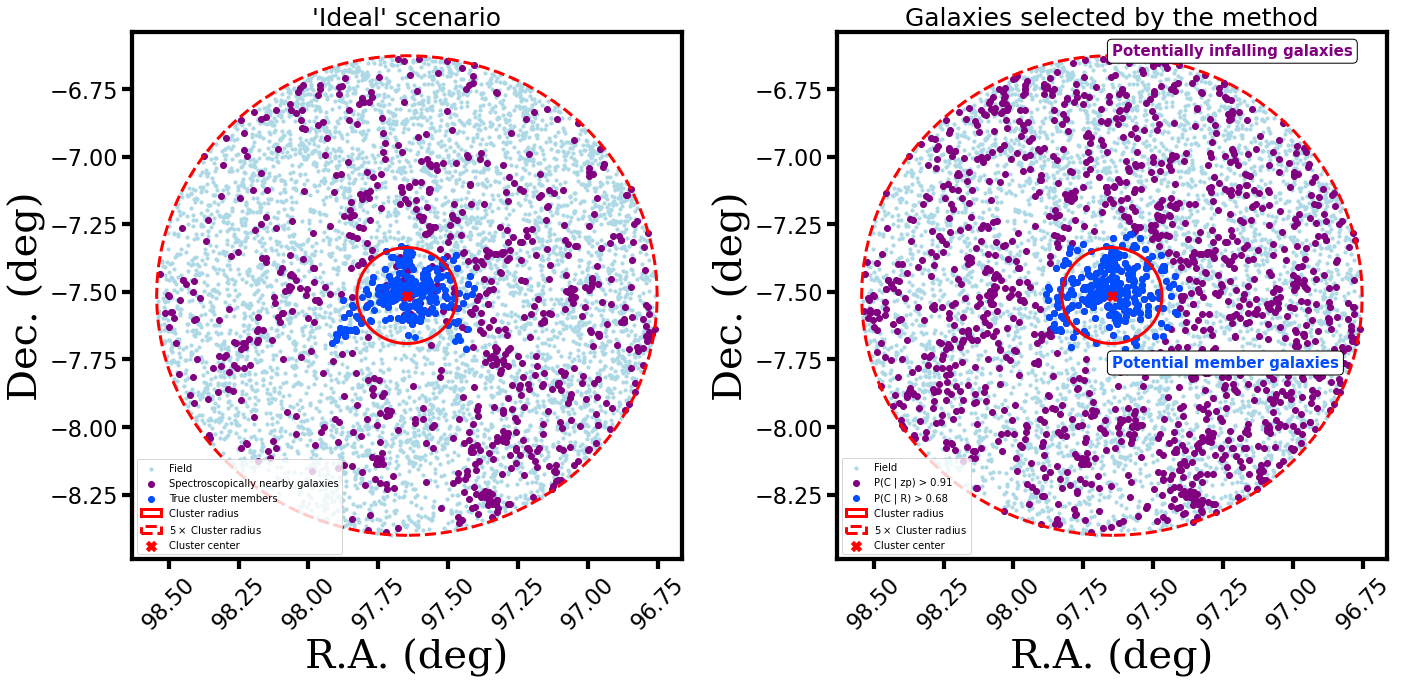

In [232]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], 
                color="lightblue", s=10, label="Field")
ax1.scatter(ra[mask_cluster][mask_members], dec[mask_cluster][mask_members], color="purple", label="Spectroscopically nearby galaxies")
ax1.scatter(halo_ra, halo_dec, color=colors1[1], label="True cluster members")


r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)
r5 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r5)
ax1.invert_xaxis()

ax1.set_title("'Ideal' scenario", fontsize=25)
ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)
ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax1.legend(fontsize=10)
ax1.tick_params(axis='x', rotation=45)




ax2.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], 
                color="lightblue", s=10, label="Field")
ax2.scatter(ra[mask_cluster][P_pz_C_array > cut_zp], dec[mask_cluster][P_pz_C_array > cut_zp], color="purple", 
                label="P(C | zp) > {:.2f}".format(cut_zp))
sc2 = ax2.scatter(ra[mask_cluster][mask_cluster_zp][Pmem_R_C > cut_R], dec[mask_cluster][mask_cluster_zp][Pmem_R_C > cut_R],
                  marker='o', color=colors1[1], rasterized=True, label="P(C | R) > {:.2f}".format(cut_R))


ax2.text(ra0, dec0+5*r200_deg, s="Potentially infalling galaxies", fontsize=15, color="purple", bbox=dict(boxstyle="round", ec="k",
                   fc="white"), fontweight="bold")
ax2.text(ra0, dec0-1.5*r200_deg, s="Potential member galaxies", fontsize=15, color=colors1[1], bbox=dict(boxstyle="round", ec="k",
                   fc="white"), fontweight="bold")

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax2.add_patch(r1)
r5 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax2.add_patch(r5)


ax2.set_title("Galaxies selected by the method", fontsize=25)
ax2.set_xlabel("R.A. (deg)", fontdict=font)
ax2.set_ylabel("Dec. (deg)", fontdict=font)
ax2.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax2.tick_params(axis='x', rotation=45)
ax2.invert_xaxis()
ax2.legend(fontsize=10, loc=3)

    
fig.tight_layout(pad=3.0)